In [3]:
# Install required packages
!pip install dlib opencv-python-headless timm gdown psutil

# Import libraries
import os#Data handling
import cv2#image/video processing
import dlib#image/video processing
import numpy as np
import torch#Deep learning
import torch.nn as nn#Deep learning
import torch.optim as optim#Deep learning
import torch.nn.functional as F#Deep learning
import zipfile
import gdown
import psutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader#Deep learning
from torchvision import transforms#Deep learning
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from PIL import Image #image/video processing
import timm  # For pretrained models#image/video processing

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Setup facial landmark detector
print("Setting up facial landmark detector...")
predictor_path = "/kaggle/working/shape_predictor_68_face_landmarks.dat"

if not os.path.exists(predictor_path):
    print("Downloading shape_predictor_68_face_landmarks.dat...")
    url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
    compressed_path = predictor_path + ".bz2"
    gdown.download(url, compressed_path, quiet=False)
    os.system(f"bzip2 -d {compressed_path}")  # Decompress the file
    print("Facial landmark model downloaded and decompressed successfully.")
else:
    print("Facial landmark model already exists, skipping download.")

# Load Dlib face detector & predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)
print("Facial landmark detector ready.\n")

Setting up facial landmark detector...


Downloading...
From: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
To: /kaggle/working/shape_predictor_68_face_landmarks.dat.bz2
100%|██████████| 64.0M/64.0M [00:04<00:00, 15.0MB/s]


Facial landmark model downloaded and decompressed successfully.
Facial landmark detector ready.



In [5]:
# Data augmentation class
class VideoAugmenter:
    """Class for applying augmentations to video frames"""
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),  # Reduced from 15
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Reduced jitter
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 1.1)),  # Milder affine
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.2, scale=(0.01, 0.05)),  # Reduced erasing
        ])

    def __call__(self, frame):
        return self.transform(frame)

In [6]:
# Feature extraction functions
def extract_facial_landmarks(frame, face_detector, landmark_predictor):
    """Extract facial landmarks from a frame"""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray)

    if len(faces) == 0:
        return None

    landmarks = landmark_predictor(gray, faces[0])
    landmarks = np.array([[p.x, p.y] for p in landmarks.parts()])
    return landmarks

def extract_deep_features(frame, model):
    """Extract deep features using a pretrained model"""
    frame = cv2.resize(frame, (224, 224))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = transforms.ToTensor()(frame)
    frame = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(frame)
    frame = frame.unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(frame)

    return features.squeeze().cpu().numpy()

def compute_optical_flow(prev_frame, current_frame):
    """Compute dense optical flow between two frames"""
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(
        prev_gray, current_gray, None,
        pyr_scale=0.5,
        levels=3,
        winsize=15,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
    )

    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    angle = angle * 180 / np.pi / 2

    hsv = np.zeros((prev_frame.shape[0], prev_frame.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = angle
    hsv[..., 1] = 255
    hsv[..., 2] = magnitude
    flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return flow, flow_rgb

def extract_video_features(video_path, frame_skip=5, max_frames=30, resize_dim=(224, 224)):
    """
    Extract features from video:
    - Optical flow
    - Facial landmarks
    - Deep features
    - Frame differences
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    # Initialize feature extractors
    augmenter = VideoAugmenter()
    feature_extractor = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    features = []
    frame_count = 0
    prev_frame = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if frame_count % frame_skip != 0:
            continue

        frame = cv2.resize(frame, resize_dim)
        frame_aug = augmenter(frame)

        frame_features = {}

        if prev_frame is not None:
            flow, flow_rgb = compute_optical_flow(prev_frame, frame)
            frame_features['optical_flow'] = flow

        landmarks = extract_facial_landmarks(frame, detector, predictor)
        if landmarks is not None:
            frame_features['landmarks'] = landmarks.flatten()
        else:
            frame_features['landmarks'] = np.zeros(68*2)

        deep_features = extract_deep_features(frame, feature_extractor)
        frame_features['deep_features'] = deep_features

        if prev_frame is not None:
            frame_diff = cv2.absdiff(frame, prev_frame)
            frame_features['frame_diff'] = frame_diff.flatten()
        else:
            frame_features['frame_diff'] = np.zeros(resize_dim[0]*resize_dim[1]*3)

        combined_features = np.concatenate([
            frame_features.get('optical_flow', np.zeros(resize_dim[0]*resize_dim[1]*2)).flatten(),
            frame_features['landmarks'],
            frame_features['deep_features'],
            frame_features['frame_diff']
        ])

        features.append(combined_features)
        prev_frame = frame

        if len(features) >= max_frames:
            break

    cap.release()

    if len(features) == 0:
        print(f"Warning: No features extracted from {video_path}")
        return None

    features = np.stack(features)
    return features

In [7]:
# Define video paths
real_videos_path = "/kaggle/input/videos/videos/real"
fake_videos_path = "/kaggle/input/videos/videos/fake"

# Load video files
print("Checking video files...")
real_videos = sorted([f for f in os.listdir(real_videos_path) if f.endswith('.mp4') or f.endswith('.avi')])[:70]
fake_videos = sorted([f for f in os.listdir(fake_videos_path) if f.endswith('.mp4') or f.endswith('.avi')])[:70]

print(f"Found {len(real_videos)} real videos and {len(fake_videos)} fake videos for training.\n")

# Prepare training data
print("Preparing training data...")
X, y = [], []

print("Processing real videos...")
for i, video in enumerate(tqdm(real_videos, desc="Real Videos")):
    video_path = os.path.join(real_videos_path, video)
    features = extract_video_features(video_path)
    if features is not None:
        X.append(features)
        y.append(0)  # Label 0 for real

print("Processing fake videos...")
for i, video in enumerate(tqdm(fake_videos, desc="Fake Videos")):
    video_path = os.path.join(fake_videos_path, video)
    features = extract_video_features(video_path)
    if features is not None:
        X.append(features)
        y.append(1)  # Label 1 for fake

# Standardize features
max_frames = max(f.shape[0] for f in X)
feature_dim = X[0].shape[1]

X_padded = np.zeros((len(X), max_frames, feature_dim))
for i, f in enumerate(X):
    X_padded[i, :f.shape[0]] = f

X = X_padded
y = np.array(y)

print("\nFeature shapes after standardization:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

if len(X) == 0 or len(y) == 0:
    raise ValueError("No valid video data was processed. Check your video files and paths.")

print(f"Final dataset shape: {X.shape}")
print(f"Class distribution: {np.bincount(y)} (0=real, 1=fake)\n")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Checking video files...
Found 70 real videos and 70 fake videos for training.

Preparing training data...
Processing real videos...


Real Videos:   0%|          | 0/70 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Real Videos: 100%|██████████| 70/70 [02:29<00:00,  2.14s/it]


Processing fake videos...


Fake Videos: 100%|██████████| 70/70 [01:55<00:00,  1.64s/it]



Feature shapes after standardization:
X shape: (140, 30, 252296)
y shape: (140,)
Final dataset shape: (140, 30, 252296)
Class distribution: [70 70] (0=real, 1=fake)

Training set size: 112
Test set size: 28


In [8]:
# Dataset class
class VideoDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return features, label

# Create dataloaders
train_dataset = VideoDataset(X_train, y_train)
test_dataset = VideoDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    drop_last=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# Model definition
# Model definition
class CNNLSTMDetector(nn.Module):
    def __init__(self, input_size, num_classes=2):
        super(CNNLSTMDetector, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 96, kernel_size=3, padding=1),  # Increased from 64
            nn.BatchNorm1d(96),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(96, 192, kernel_size=3, padding=1),  # Increased from 128
            nn.BatchNorm1d(192),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(192, 384, kernel_size=3, padding=1),  # Added third layer
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.lstm = nn.LSTM(
            input_size=384,
            hidden_size=192,  # Increased from 128
            num_layers=2,  # Restored to 2 layers
            bidirectional=True,
            batch_first=True
        )
        self.attention = nn.Sequential(
            nn.Linear(384, 96),  # Adjusted for bidirectional LSTM (192 * 2)
            nn.Tanh(),
            nn.Linear(96, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(384, 96),  # Adjusted for bidirectional LSTM
            nn.ReLU(),
            nn.Dropout(0.5),  # Reduced from 0.7
            nn.Linear(96, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        attention_weights = self.attention(lstm_out)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        out = self.fc(context_vector)
        return out, attention_weights

# Initialize model
input_size = X.shape[2]  # From Cell 5 of your pipeline
model = CNNLSTMDetector(input_size)
model = model.to(device)
print("\nModel architecture:")
print(model)


Model architecture:
CNNLSTMDetector(
  (cnn): Sequential(
    (0): Conv1d(252296, 96, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(96, 192, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(192, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(384, 192, num_layers=2, batch_first=True, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=384, out_features=96


Starting training...

Epoch 1/20


Train Loss: 0.6809 | Train Acc: 0.6875
Val Loss: 0.6725 | Val Acc: 0.8571
LR: 9.76e-05
Saved new best model

Epoch 2/20


Train Loss: 0.6521 | Train Acc: 0.8839
Val Loss: 0.6430 | Val Acc: 0.9643
LR: 9.05e-05
Saved new best model

Epoch 3/20


Train Loss: 0.6153 | Train Acc: 0.9107
Val Loss: 0.5989 | Val Acc: 0.9643
LR: 7.95e-05
Saved new best model

Epoch 4/20


Train Loss: 0.5544 | Train Acc: 0.9732
Val Loss: 0.5503 | Val Acc: 0.9286
LR: 6.56e-05
Saved new best model

Epoch 5/20


Train Loss: 0.4951 | Train Acc: 0.9554
Val Loss: 0.4906 | Val Acc: 0.9286
LR: 5.03e-05
Saved new best model

Epoch 6/20


Train Loss: 0.4247 | Train Acc: 1.0000
Val Loss: 0.4281 | Val Acc: 0.9643
LR: 3.49e-05
Saved new best model

Epoch 7/20


Train Loss: 0.3697 | Train Acc: 0.9911
Val Loss: 0.3846 | Val Acc: 0.9643
LR: 2.10e-05
Saved new best model

Epoch 8/20


Train Loss: 0.3448 | Train Acc: 0.9911
Val Loss: 0.3599 | Val Acc: 0.9643
LR: 1.00e-05
Saved new best model

Epoch 9/20


Train Loss: 0.3068 | Train Acc: 0.9911
Val Loss: 0.3461 | Val Acc: 0.9286
LR: 2.93e-06
Saved new best model

Epoch 10/20


Train Loss: 0.2841 | Train Acc: 1.0000
Val Loss: 0.3410 | Val Acc: 0.9643
LR: 5.00e-07
Saved new best model

Epoch 11/20


Train Loss: 0.3363 | Train Acc: 0.9464
Val Loss: 0.3324 | Val Acc: 0.9643
LR: 2.93e-06
Saved new best model

Epoch 12/20


Train Loss: 0.2879 | Train Acc: 1.0000
Val Loss: 0.3317 | Val Acc: 0.9643
LR: 1.00e-05
Saved new best model

Epoch 13/20


Train Loss: 0.2782 | Train Acc: 1.0000
Val Loss: 0.3235 | Val Acc: 0.9643
LR: 2.10e-05
Saved new best model

Epoch 14/20


Train Loss: 0.2616 | Train Acc: 0.9911
Val Loss: 0.3059 | Val Acc: 0.9286
LR: 3.49e-05
Saved new best model

Epoch 15/20


Train Loss: 0.2562 | Train Acc: 0.9911
Val Loss: 0.2593 | Val Acc: 0.9643
LR: 5.03e-05
Saved new best model

Epoch 16/20


Train Loss: 0.1899 | Train Acc: 1.0000
Val Loss: 0.2095 | Val Acc: 0.9643
LR: 6.56e-05
Saved new best model

Epoch 17/20


Train Loss: 0.1397 | Train Acc: 1.0000
Val Loss: 0.1895 | Val Acc: 0.9286
LR: 7.95e-05
Saved new best model

Epoch 18/20


Train Loss: 0.0912 | Train Acc: 1.0000
Val Loss: 0.1780 | Val Acc: 0.9286
LR: 9.05e-05
Saved new best model

Epoch 19/20


Train Loss: 0.0593 | Train Acc: 1.0000
Val Loss: 0.1760 | Val Acc: 0.9286
LR: 9.76e-05
Saved new best model

Epoch 20/20


Train Loss: 0.0317 | Train Acc: 1.0000
Val Loss: 0.1689 | Val Acc: 0.9286
LR: 1.00e-04
Saved new best model


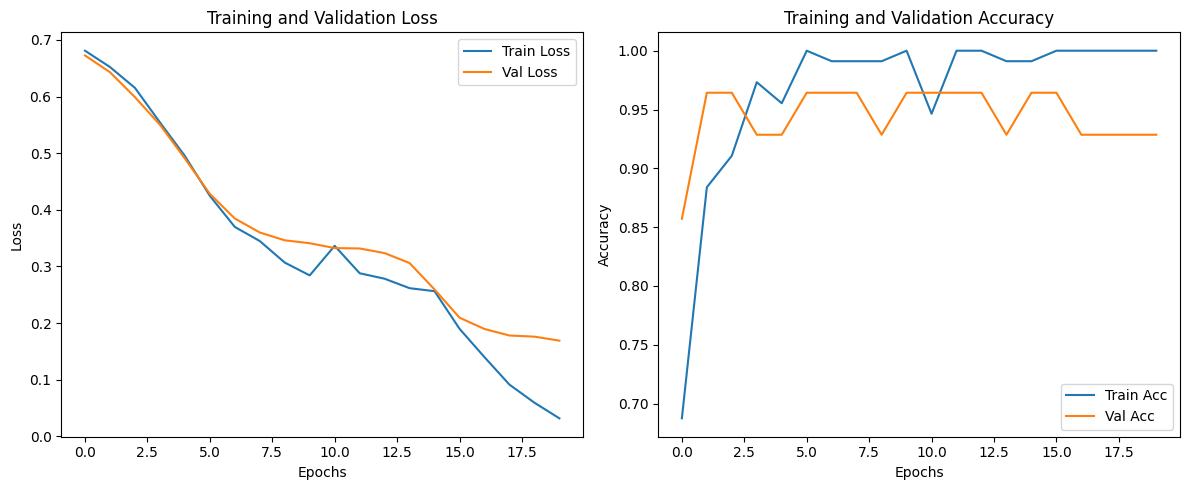

In [9]:
# Training setup
# Add class weights to penalize misclassifying real videos
class_weights = torch.tensor([1.3, 1.0]).to(device)  # Higher weight for real (class 0)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)  # Increased weight decay
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-7)  # Lower min LR

best_val_loss = float('inf')
patience = 3  # Tighter early stopping
patience_counter = 0

# Training functions (unchanged from your pipeline)
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

# Training loop
print("\nStarting training...")
epochs = 20  # Reduced epochs
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate_epoch(model, test_loader, criterion, device)
    scheduler.step()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        print("Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping after {patience} epochs without improvement")
            break

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('/kaggle/working/training_metrics.png')
plt.show()

/tmp/ipykernel_31/3224795528.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))



Debugging test set predictions...


Debugging Test Set: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]



Total Misclassifications: 2

Misclassified Example 1:
True Label: Fake
Predicted Label: Real
Probabilities: Real=0.9184, Fake=0.0816


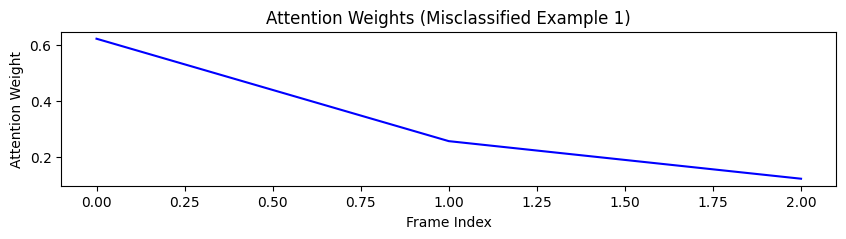


Misclassified Example 2:
True Label: Fake
Predicted Label: Real
Probabilities: Real=0.8733, Fake=0.1267


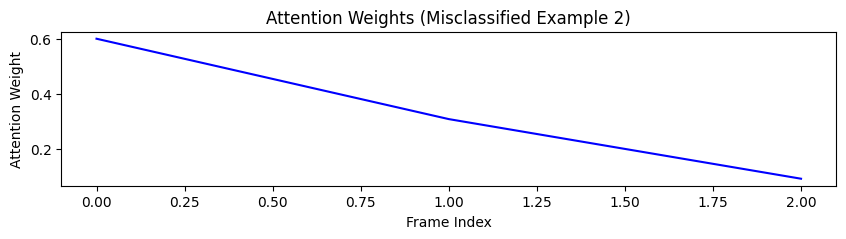

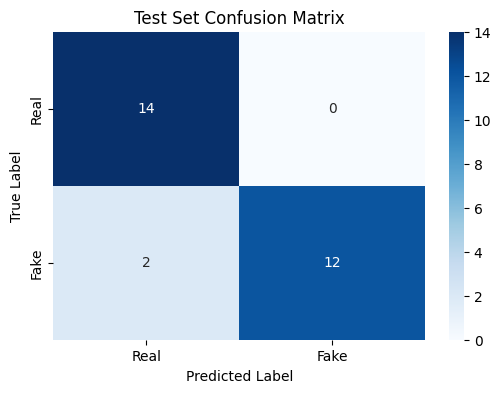


=== Test Set Metrics ===
Accuracy: 0.9286
Precision: 1.0000
Recall: 0.8571
F1 Score: 0.9231
AUC-ROC: 1.0000


In [10]:
# Load best model
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()

# Evaluate and debug test set
def debug_test_predictions(model, dataloader, device):
    all_preds = []
    all_labels = []
    all_probs = []
    misclassified = []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader, desc="Debugging Test Set")):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs, attention_weights = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            for i in range(inputs.size(0)):
                if preds[i] != labels[i]:  # Track misclassifications
                    misclassified.append({
                        'batch_idx': batch_idx,
                        'sample_idx': i,
                        'true_label': labels[i].item(),
                        'pred_label': preds[i].item(),
                        'probs': probs[i].cpu().numpy(),
                        'attention_weights': attention_weights[i].squeeze().cpu().numpy()
                    })
                all_preds.append(preds[i].cpu().numpy())
                all_labels.append(labels[i].cpu().numpy())
                all_probs.append(probs[i].cpu().numpy())
    
    # Print misclassification details
    print(f"\nTotal Misclassifications: {len(misclassified)}")
    for idx, item in enumerate(misclassified[:3]):  # Show up to 3 examples
        print(f"\nMisclassified Example {idx+1}:")
        print(f"True Label: {'Real' if item['true_label'] == 0 else 'Fake'}")
        print(f"Predicted Label: {'Real' if item['pred_label'] == 0 else 'Fake'}")
        print(f"Probabilities: Real={item['probs'][0]:.4f}, Fake={item['probs'][1]:.4f}")
        plt.figure(figsize=(10, 2))
        plt.plot(item['attention_weights'], 'b-')
        plt.title(f'Attention Weights (Misclassified Example {idx+1})')
        plt.xlabel('Frame Index')
        plt.ylabel('Attention Weight')
        plt.savefig(f'/kaggle/working/misclassified_attention_{idx+1}.png')
        plt.show()
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title('Test Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('/kaggle/working/confusion_matrix_test.png')
    plt.show()

    return all_labels, all_preds, all_probs

# Run debugging
print("\nDebugging test set predictions...")
test_labels, test_preds, test_probs = debug_test_predictions(model, test_loader, device)

# Print metrics
def print_metrics(y_true, y_pred, y_probs, dataset_name):
    print(f"\n=== {dataset_name} Set Metrics ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_true, [p[1] for p in y_probs]):.4f}")

print_metrics(test_labels, test_preds, test_probs, "Test")


Visualizing attention weights...

Example 1
True Label: Fake
Predicted: Fake


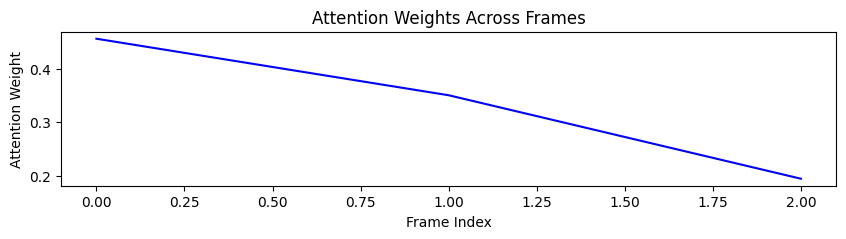


Example 2
True Label: Fake
Predicted: Real


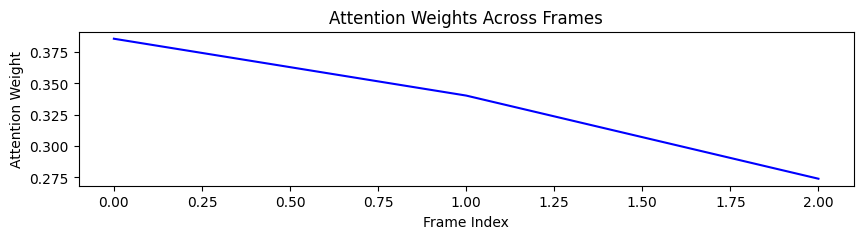


Example 3
True Label: Real
Predicted: Real


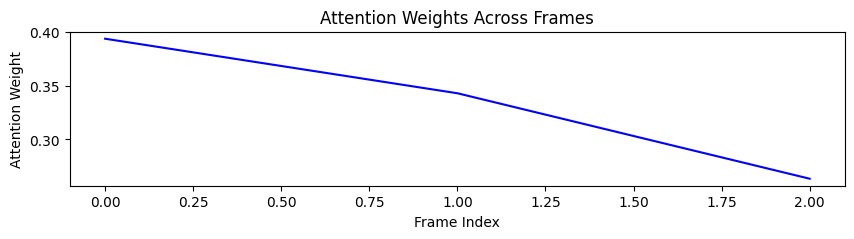

In [10]:
# Import required libraries (should already be imported in earlier cells)
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# Function to visualize attention weights
def visualize_attention(model, dataloader, device, num_examples=3):
    """Visualize attention weights for model interpretability"""
    model.eval()
    examples = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs, attention_weights = model(inputs)
        attention_weights = attention_weights.cpu().numpy()  # Corrected line
        inputs = inputs.cpu().numpy()
        for i in range(inputs.shape[0]):
            if examples >= num_examples:
                return
            print(f"\nExample {examples+1}")
            print(f"True Label: {'Fake' if labels[i] == 1 else 'Real'}")
            pred = torch.argmax(outputs[i]).item()
            print(f"Predicted: {'Fake' if pred == 1 else 'Real'}")
            plt.figure(figsize=(10, 2))
            plt.plot(attention_weights[i], 'b-')
            plt.title('Attention Weights Across Frames')
            plt.xlabel('Frame Index')
            plt.ylabel('Attention Weight')
            plt.savefig(f'/kaggle/working/attention_example_{examples+1}.png')  # Save plot
            plt.show()
            examples += 1

# Run visualization
print("\nVisualizing attention weights...")
visualize_attention(model, test_loader, device, num_examples=3)


To upload a video from your local system:
1. Go to the Kaggle notebook interface.
2. Click '+ Add Data' in the top-right corner of the Data panel (right sidebar).
3. Select 'Upload' and choose your video file (.mp4 or .avi) from your local system.
4. Wait for the upload to complete. The file will appear in /kaggle/working/ or a temporary input directory.
5. Run this cell to select and predict on the uploaded video.


Available video files:
1. W022_light_rightdown_surprise_camera_front.mp4 (/kaggle/input/testset5/W022_light_rightdown_surprise_camera_front.mp4)
2. WIN_20250325_23_32_22_Pro.mp4 (/kaggle/input/testset4/WIN_20250325_23_32_22_Pro.mp4)
3. 826_M019.mp4 (/kaggle/input/testset3/826_M019.mp4)


Enter the number of the video to predict (1-3):  1



Processing video: W022_light_rightdown_surprise_camera_front.mp4


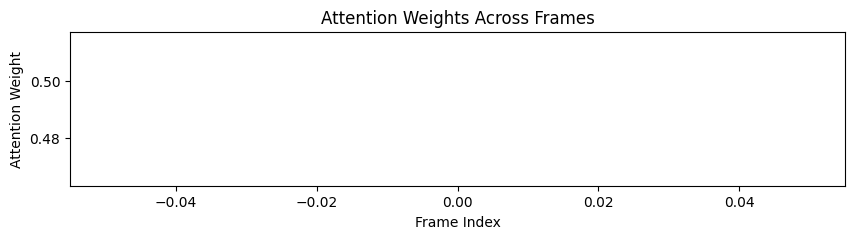


=== Prediction Results ===
Prediction: Real (confidence: 0.6880)
Real probability: 0.6880
Fake probability: 0.3120


In [13]:
# Import required libraries (assumed to be imported earlier)
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming extract_video_features is defined as in your pipeline
# If not, include it from Cell 4 of the previous response

def predict_video(video_path, model, device, threshold=0.5):
    """
    Predict whether a video is real or fake and visualize attention weights.
    
    Args:
        video_path (str): Path to the video file
        model: Trained PyTorch model (CNNLSTMDetector)
        device: Device to run inference on (cuda/cpu)
        threshold (float): Confidence threshold for classification
    
    Returns:
        dict: Prediction results with confidence and attention weights
    """
    print(f"\nProcessing video: {os.path.basename(video_path)}")
    features = extract_video_features(video_path)
    if features is None:
        return {"error": "Unable to process video"}
    input_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output, attention_weights = model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, prediction = torch.max(probabilities, dim=1)
        confidence = confidence.item()
        prediction = prediction.item()
    attention_weights = attention_weights.squeeze().cpu().numpy()
    result = {
        "prediction": "Fake" if prediction == 1 else "Real",
        "confidence": confidence,
        "real_prob": probabilities[0][0].item(),
        "fake_prob": probabilities[0][1].item(),
        "attention_weights": attention_weights.tolist()
    }
    plt.figure(figsize=(10, 2))
    plt.plot(attention_weights[0], 'b-')
    plt.title('Attention Weights Across Frames')
    plt.xlabel('Frame Index')
    plt.ylabel('Attention Weight')
    plt.savefig('/kaggle/working/attention_weights.png')
    plt.show()
    print(f"\n=== Prediction Results ===")
    print(f"Prediction: {result['prediction']} (confidence: {confidence:.4f})")
    print(f"Real probability: {result['real_prob']:.4f}")
    print(f"Fake probability: {result['fake_prob']:.4f}")
    return result

# Function to list available videos and prompt for selection
def select_video():
    # Define directories to search for videos
    search_dirs = [
        "/kaggle/input/testset5",
        "/kaggle/input/testset4",
        "/kaggle/input/testset3"
    ]
    
    # Collect all video files
    video_files = []
    for dir_path in search_dirs:
        if os.path.exists(dir_path):
            for f in os.listdir(dir_path):
                if f.endswith(('.mp4', '.avi')):
                    video_files.append(os.path.join(dir_path, f))
    
    if not video_files:
        print("No video files found in /kaggle/input/videos/ or /kaggle/working/")
        return None
    
    # Display available videos
    print("\nAvailable video files:")
    for i, video_path in enumerate(video_files, 1):
        print(f"{i}. {os.path.basename(video_path)} ({video_path})")
    
    # Prompt for selection (simulate user input in Kaggle)
    try:
        choice = int(input("Enter the number of the video to predict (1-{}): ".format(len(video_files))))
        if 1 <= choice <= len(video_files):
            return video_files[choice - 1]
        else:
            print("Invalid choice. Selecting first video by default.")
            return video_files[0]
    except (ValueError, IndexError):
        print("Invalid input. Selecting first video by default.")
        return video_files[0]

# Instructions for uploading a video
print("""
To upload a video from your local system:
1. Go to the Kaggle notebook interface.
2. Click '+ Add Data' in the top-right corner of the Data panel (right sidebar).
3. Select 'Upload' and choose your video file (.mp4 or .avi) from your local system.
4. Wait for the upload to complete. The file will appear in /kaggle/working/ or a temporary input directory.
5. Run this cell to select and predict on the uploaded video.
""")

# Select and predict on a video
test_video_path = select_video()
if test_video_path:
    result = predict_video(test_video_path, model, device)
else:
    print("No video selected. Please upload a video and try again.")

In [ ]:
# System resource monitoring
def print_system_stats():
    mem = psutil.virtual_memory()
    print("\nSystem Resource Usage:")
    print(f"Memory Used: {mem.used / (1024 ** 3):.2f} GB")
    print(f"Memory Available: {mem.available / (1024 ** 3):.2f} GB")
    print(f"Memory Percent Used: {mem.percent}%")
    print(f"CPU Usage: {psutil.cpu_percent()}%")

print_system_stats()

# Save final model
final_model_path = "/kaggle/working/deepfake_detector_enhanced.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': input_size,
    'class_names': ['Real', 'Fake']
}, final_model_path)
print(f"\nFinal model saved to: {final_model_path}")

print("\nEnhanced deepfake detection pipeline completed successfully!")